In [2]:
from __future__ import print_function
import keras
from keras.models import  Model
from keras.layers import Dense, Dropout, Input, Flatten, PReLU, LeakyReLU
from keras.optimizers import RMSprop, Adam, SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from time import time
import traceback
import logging
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from GA.geneticAlgorithm import GenerationalGA
from GA.parentSelector.parentSelector import RandomParentSelector, LinealOrder, TournamentSelection
from GA.parentSelector.parentSelector import WheelSelection, LinealOrderII
from utils.datamanager import DataManager


class Layer(object):
    def __init__(self, units=128, activation='relu', dropout=0):
        self.units = units
        self.posible_activations = ['relu', 'sigmoid', 'tanh', 'elu', 'prelu', 'leakyreLu']
        assert activation in self.posible_activations
        self.activation = activation
        self.dropout = dropout
        self.units_lim = 1024
        self.units_prob = 0.2
        self.act_prob = 0.2
        self.drop_prob = 0.2

    def cross(self, other_layer):
        new_units = self.cross_units(other_layer.units)
        new_activation = self.cross_activation(other_layer.activation)
        new_dropout = self.cross_dropout(other_layer.dropout)
        return Layer(new_units, new_activation, new_dropout)

    def cross_activation(self, other_activation):
        if np.random.rand() > 0.5:
            return self.activation
        return other_activation

    def cross_dropout(self, other_dropout):
        b = np.random.rand()
        return self.dropout * (1 - b) + b * other_dropout

    def cross_units(self, other_units):
        b = np.random.rand()
        return int(self.units * (1 - b) + other_units * b)

    def mutate(self):
        aleatory = np.random.rand(4)
        if aleatory[0] < self.units_prob:
            self.units = np.random.randint(0, self.units_lim)
        if aleatory[1] < self.act_prob:
            self.activation = random.choice(self.posible_activations)
        if aleatory[2] < self.drop_prob:
            self.dropout = np.random.rand()

    def compare(self, other_layer):
        if self.units != other_layer.units:
            return False
        if self.activation != other_layer.activation:
            return False
        if self.dropout != other_layer.dropout:
            return False
        return True

    def self_copy(self):
        return Layer(self.units, self.activation, self.dropout)

    def random_layer(self):
        units = np.random.randint(0, self.units_lim)
        act = random.choice(self.posible_activations)
        drop = np.random.rand()
        return Layer(units, act, drop)

    def __repr__(self):
        return "U:%d|A:%s|D:%0.3f" % (self.units, self.activation, self.dropout)


class Cromosome(object):

    def __init__(self, layers=[], fit=None):
        assert type(layers) == list
        self.n_layers = len(layers)
        self.layers = layers
        self.max_layers = 10
        self.layer_prob = 0.1
        self.fit = None
        self.evaluator = Fitness.get_instance()

    def set_fitness(self, fit):
        self.evaluator = fit

    def random_indiv(self):
        n_layers = np.random.randint(0, self.max_layers)
        layers = [Layer().random_layer() for i in range(n_layers)]
        return Cromosome(layers)

    @staticmethod
    def simple_indiv():
        return Cromosome([Layer()])

    def cross(self, other_cromosome):
        new_layers = []

        if self.n_layers == 0:
            return other_cromosome

        n_intersection = np.random.randint(0, self.n_layers)
        for i in range(self.n_layers):
            if i < n_intersection or i >= other_cromosome.n_layers:
                new_layers.append(self.layers[i].self_copy())
            else:
                try:
                    new_layers.append(self.layers[i].cross(other_cromosome.layers[i - n_intersection]))
                except IndexError:
                    print("Problem with index %d" % i)
                    print("Intersection point at %d" % n_intersection)
                    print(len(self.layers), self.layers)
                    print(len(other_cromosome.layers), other_cromosome.layers)
                    print(len(new_layers), new_layers)
                    raise IndexError
        return Cromosome(new_layers)

    def mutate(self):
        for i in range(self.n_layers):
            self.layers[i].mutate()
        if np.random.rand() < self.layer_prob and self.n_layers < self.max_layers:
            self.layers.append(Layer().random_layer())
            self.n_layers = len(self.layers)

    def equals(self, other_cromosome):
        if self.n_layers != other_cromosome.n_layers:
            return False
        for i in range(self.n_layers):
            if not self.layers[i].compare(other_cromosome.layers[i]):
                return False
        return True

    def __repr__(self):
        rep = ""
        for i in range(self.n_layers):
            rep += "%d - %s \n" % (i, self.layers[i])
        return rep

    def fitness(self):
        if self.fit is None:
            self.fit = self.evaluator.calc(self)
        return self.fit


class Fitness:
    __instance = None

    @staticmethod
    def get_instance():
        """ Static access method. """
        if Fitness.__instance == None:
            Fitness()
        return Fitness.__instance

    def __init__(self):
        """ Virtually private constructor. """
        if Fitness.__instance != None:
            raise Exception("This class is a singleton!")
        else:
            Fitness.__instance = self

    def set_params(self, data, batch_size=128, epochs=100, early_stop=True, reduce_plateau=True, verbose=1):
        self.batch_size = batch_size
        self.epochs = epochs
        self.early_stop = early_stop
        self.reduce_plateu = reduce_plateau
        self.verb = verbose
        (self.x_train, self.y_train), (self.x_test, self.y_test), (self.x_val, self.y_val) = data
        self.num_clases = self.y_train.shape[1]
        self.callbacks = []
        if self.early_stop and keras.__version__=='2.2.4':
            self.callbacks.append(EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True))
        elif self.early_stop:
            self.callbacks.append(EarlyStopping(monitor='val_acc', patience=10))
        if self.reduce_plateu:
            self.callbacks.append(ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=5, verbose=self.verb))
        return self

    def calc(self, chromosome):
        try:
            model = self.decode(chromosome)
            h = model.fit(self.x_train, self.y_train,
                              batch_size=self.batch_size,
                              epochs=self.epochs,
                              verbose=self.verb,
                              validation_data=(self.x_val, self.y_val),
                              callbacks=self.callbacks)
            score = model.evaluate(self.x_val, self.y_val, verbose=0)
            score_t = model.evaluate(self.x_test, self.y_test, verbose=0)
        except Exception as e:
            score = [0,0]
            score_t = [0,0]
            print("Some Error with gen:")
            print(chromosome)
            logging.error(traceback.format_exc())
        if self.verb:
            print('Val loss: %0.4f, Test loss: %0.4f' % (score[0], score_t[0]))
            print('Val accuracy: %0.4f, Test accuracy: %0.4f' % (score[1], score_t[1]))
            self.show_result(h, 'acc')
            self.show_result(h, 'loss')
        return score[1]

    def decode(self, chromosome):

        inp = Input(shape=(28, 28, 1))
        x = Flatten()(inp)
        for i in range(chromosome.n_layers):
            act = chromosome.layers[i].activation
            if act in ['relu', 'sigmoid', 'tanh', 'elu']:
                x = Dense(chromosome.layers[i].units, activation=act)(x)
            elif act == 'prelu':
                x = Dense(chromosome.layers[i].units)(x)
                x = PReLU()(x)
            else:
                x = Dense(chromosome.layers[i].units)(x)
                x = LeakyReLU()(x)
            x = Dropout(chromosome.layers[i].dropout)(x)
        x = Dense(self.num_clases, activation='softmax')(x)

        model = Model(inputs=inp, outputs=x)
        if self.verb:
            model.summary()
        model.compile(loss='categorical_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])
        return model

    def show_result(self, history, metric='acc'):
        epochs = np.linspace(0, len(history.history['acc']) - 1, len(history.history['acc']))
        plt.plot(epochs, history.history['val_%s' % metric], label='validation')
        plt.plot(epochs, history.history[metric], label='train')
        plt.legend()
        plt.xlabel('Epochs')
        plt.ylabel(metric)
        plt.show()

    def calc_mean(self, chromosome, iters=5):
        f = []
        ti = time()
        for i in range(iters):
            f.append(self.calc(chromosome))
        print("Acc: %0.3f" % np.mean(f), np.std(f), np.max(f))
        print("Time elapsed: %0.3f" % (time() - ti))

(9432, 28, 28, 1) train samples
(2359, 28, 28, 1) validation samples
(1991, 28, 28, 1) test samples
Generic algorith params:
Number of generations: 40
Population size: 15
num parents: 4
offspring size: 11
1) best fit: 0.990
5) best fit: 0.990
9) best fit: 0.991
13) best fit: 0.991
17) best fit: 0.991
21) best fit: 0.991
25) best fit: 0.992
29) best fit: 0.992
Some Error with gen:
0 - U:817|A:relu|D:0.366 
1 - U:452|A:elu|D:0.860 
2 - U:639|A:relu|D:0.879 

Some Error with gen:
0 - U:115|A:leakyreLu|D:0.767 
1 - U:325|A:relu|D:0.297 
2 - U:385|A:tanh|D:0.736 

Some Error with gen:
0 - U:86|A:tanh|D:0.510 
1 - U:355|A:elu|D:0.501 

Some Error with gen:
0 - U:529|A:prelu|D:0.831 

Some Error with gen:
0 - U:693|A:leakyreLu|D:0.501 

Some Error with gen:
0 - U:578|A:prelu|D:0.332 
1 - U:345|A:elu|D:0.567 
2 - U:385|A:tanh|D:0.566 

Some Error with gen:
0 - U:479|A:prelu|D:0.902 
1 - U:78|A:elu|D:0.696 

Some Error with gen:
0 - U:543|A:tanh|D:0.417 

Some Error with gen:
0 - U:477|A:relu|D

Some Error with gen:
0 - U:928|A:tanh|D:0.090 
1 - U:626|A:relu|D:0.341 
2 - U:898|A:tanh|D:0.145 

Some Error with gen:
0 - U:729|A:relu|D:0.090 
1 - U:648|A:relu|D:0.150 

Some Error with gen:
0 - U:442|A:relu|D:0.942 
1 - U:670|A:relu|D:0.165 

Some Error with gen:
0 - U:442|A:relu|D:0.090 
1 - U:488|A:relu|D:0.489 
2 - U:622|A:elu|D:0.447 

Some Error with gen:
0 - U:171|A:relu|D:0.090 
1 - U:620|A:relu|D:0.696 

Some Error with gen:
0 - U:442|A:relu|D:0.090 
1 - U:927|A:relu|D:0.332 

Some Error with gen:
0 - U:926|A:relu|D:0.090 
1 - U:562|A:prelu|D:0.291 

Some Error with gen:
0 - U:442|A:relu|D:0.090 
1 - U:648|A:relu|D:1.000 

Some Error with gen:
0 - U:442|A:relu|D:0.090 
1 - U:648|A:prelu|D:0.598 

Some Error with gen:
0 - U:442|A:relu|D:0.090 
1 - U:476|A:relu|D:0.258 

41) best fit: 0.992
Some Error with gen:
0 - U:442|A:relu|D:0.090 
1 - U:526|A:relu|D:0.580 

Some Error with gen:
0 - U:442|A:relu|D:0.090 
1 - U:536|A:tanh|D:0.999 

Some Error with gen:
0 - U:557|A:relu|D

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


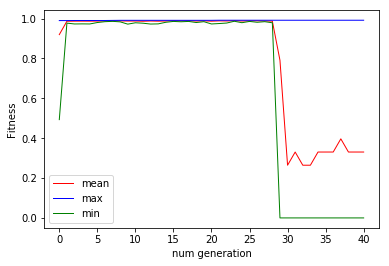

Total elapsed time: 26613.664
Some Error with gen:
0 - U:442|A:relu|D:0.090 
1 - U:648|A:relu|D:0.598 

Some Error with gen:
0 - U:442|A:relu|D:0.090 
1 - U:648|A:relu|D:0.598 

Some Error with gen:
0 - U:442|A:relu|D:0.090 
1 - U:648|A:relu|D:0.598 

Some Error with gen:
0 - U:442|A:relu|D:0.090 
1 - U:648|A:relu|D:0.598 

Some Error with gen:
0 - U:442|A:relu|D:0.090 
1 - U:648|A:relu|D:0.598 

Acc: 0.000 0.0 0
Time elapsed: 230.433


In [4]:
l = Layer(516, 'relu', 0.2)
l2 = Layer(516, 'relu', 0.2)
c = Cromosome([l, l2])
clases = [4, 9]

ps = {'random':RandomParentSelector(), 'lineal':LinealOrder(), 'wheel':WheelSelection(), 
      'tournament':TournamentSelection(5)}

# params:
dataset = 'mnist'
classes = [4, 9]
parents_selector_key = 'wheel'
num_parents = 0.5
generations = 2
population = 2
maximize_fit = True

# Load data
dm = DataManager(dataset, clases=classes)
data = dm.load_data()
fitness = Fitness.get_instance()
fitness.set_params(data, verbose=0, reduce_plateau=False)

p = ps[parents_selector_key]

ti_all = time()
generational = GenerationalGA(num_parents=0.3, chromosome=c, parent_selector=p, generations=40, num_population=15, crossover_prob=0.5,
                 mutation_prob=0.7, maximize_fitness=True)
winner, best_fit, ranking = generational.evolve()
print("Total elapsed time: %0.3f" % (time() - ti_all))
fitness.calc_mean(winner)

In [ ]:
class A:
    def __init__(self, N_participants=3):
        self.N = N_participants
        self.history_fitness = {}
        
    def set_params(self,maximize, history):
        self.maximize = maximize
        self.history_fitness = history
        
    def eval_individual(self, chrom):
        gen = chrom.__repr__()
        if gen not in self.history_fitness.keys():
            self.history_fitness[gen] = chrom.fitness()
        elif chrom.fit is None:
            chrom.fit = self.history_fitness[gen]
        return chrom.fit
    
    def get_one_offspring(self, population):
        idxs = np.linspace(0, len(population) - 1, len(population)).astype(np.int32)
        idxs_perm = np.random.permutation(idxs)
        participants_1 = [population[idxs_perm[i]] for i in range(self.N)]
        participants_2 = [population[idxs_perm[-i]] for i in range(1, self.N + 1)]
        win_1 = np.argmax([self.eval_individual(chrom) for chrom in participants_1])
        win_2 = np.argmax([self.eval_individual(chrom) for chrom in participants_2])
        parent1 = participants_1[win_1]
        parent2 = participants_2[win_2]
        offspring = parent1.cross(parent2)
        offspring.mutate()
        self.eval_individual(offspring)
        return offspring, (parent1, parent2)
        
    def next_gen(self, population, num_offspring=1):
        next_generation = []
        all_parents = []
        for n in range(num_offspring):
            print(len(population))
            offspring, parents = self.get_one_offspring(population)
            next_generation.append(offspring)
            all_parents.append(parents)
        return next_generation, all_parents
    
class B:
    def __init__(self, n):
        self.n = n
        self.fit = self.n
        
    def __repr__(self):
        return str(self.n)

    def fitness(self):
        return self.n
    
    def cross(self, aB):
        return B(np.mean([self.n, aB.n]))
    
    def mutate(self):
        self.n += np.random.rand()*0
        
a = [0,1,2,3,4,5,6,7,8,9,10]
b = [B(aux) for aux in a]
a_ = LinealOrder()
next_generation, all_parents = a_.next_gen(b, 10000)

In [ ]:
l1 = Layer(10, 'relu', 0.1)
l2 = Layer(20, 'elu', 0.2)
l3 = Layer(30, 'prelu', 0.3)

c1 = Cromosome([l1])
c2 = Cromosome([l2])
c3 = Cromosome([l3])
c12 = Cromosome([l1, l2])
c21 = Cromosome([l2, l1])
c13 = Cromosome([l1, l3])
c31 = Cromosome([l3, l1])
c23 = Cromosome([l2, l3])
c32 = Cromosome([l3, l2])
c123 = Cromosome([l1, l2, l3])
c132 = Cromosome([l1, l3, l2])
c213 = Cromosome([l2, l1, l3])
c231 = Cromosome([l2, l3, l1])
c312 = Cromosome([l3, l1, l2])
c321 = Cromosome([l3, l2, l1])

F = Fitness_str(c321)

population = [c1, c2, c3, c12, c21, c13, c31, c23, c32, c123, c132, c213, c231, c312, c321]
for c in population:
    c.set_fitness(F)
    
population = population[:10]
_=[print(a.fitness(), end=' ') for a in population]
print('\n', F.crom)
print(c321.fitness())

In [ ]:
r = RandomParentSelector(num_offspring=3, history_fitness={}, maximize_fit=True)
next_generation, all_parents = r.next_gen(population)

In [ ]:
print(type(next_generation), len(next_generation), type(all_parents), len(all_parents))
print(next_generation[0], next_generation[0].fitness())
print(all_parents[0][0], all_parents[0][0].fitness())
print(all_parents[0][1], all_parents[0][1].fitness())

In [ ]:
new_pop = r.replace(population, next_generation, all_parents)

In [ ]:
for a , b in zip(new_pop, population):
    print(b)

In [ ]:
class printer:
    def prt(self, objecto):
        print(objecto)
        return
        
class A(object):
    def __init__(self, name, printer):
        self.printer = printer
        self.name = name
        
    def self_print(self):
        self.printer.prt(self)
        
    def __repr__(self):
        return self.name

In [ ]:
p = printer()
p.prt('hi')

a = A('wolo', p)

In [ ]:
a.self_print()

In [ ]:



class chrom:
    def __init__(self, x=0, y=0):
        self.x = x
        self.y = y
        self.mut_prob = 0.2
        self.fit = None
    
    def set_fitness(self, fit):
        self.evaluator = fit
        
    def random_indiv(self):
        x = 10 * np.random.rand()
        y = 10 * np.random.rand()
        return chrom(x, y)
    
    def simple_indiv(self):
        return chrom(0, 0)
        
    def cross(self, other_cromosome):
        bx = np.random.rand()
        by = np.random.rand()
        x = bx * self.x + (1 - bx) * other_cromosome.x
        y = by * self.y + (1 - by) * other_cromosome.y
        return chrom(x, y)
        
    
    def mutate(self):
        if np.random.rand() < self.mut_prob:
            self.x = 10 * np.random.rand()
        if np.random.rand() < self.mut_prob:
            self.y = 10 * np.random.rand()
            
    def equals(self, other_cromosome):
        return (self.x == other_cromosome.x) and (self.y == other_cromosome.y)
    
    def __repr__(self):
        return "(%0.3f, %0.3f)" % (self.x, self.y)
    
    def fitness(self):
        self.fit = self.x * np.sin(4 * self.x) + 1.1 * self.y * np.sin(2 * self.y)
        return self.fit

In [ ]:
pop_size = 12
mut_prob = 0.2
generations = 1000
num_parents = 0.5

c = chrom()
ps = [RandomParentSelector(), LinealOrder(), LinealOrderII(), WheelSelection(), TournamentSelection(5)]
p = ps[2]
generational = GenerationalGA(num_parents=num_parents, chromosome=c, parent_selector=p, generations=generations,
                              num_population=pop_size, crossover_prob=0.5,
                              mutation_prob=0.7, maximize_fitness=False)

winner, best_fit, ranking = generational.evolve()
print(best_fit)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import ma
from matplotlib import ticker, cm

N = 1000
x = np.linspace(0, 10.0, N)
y = np.linspace(0, 10.0, N)

X, Y = np.meshgrid(x, y)
z = X * np.sin(4 * X) + 1.1 * Y * np.sin(2 * Y) 
print(np.min(z), np.max(z))
z += np.abs(np.min(z))
min_z = np.min(z)
max_z = np.max(z)
max_idxs = []
min_idxs = []
for i in range(N):
    for k in range(N):
        if z[i, k] == min_z:
            min_idxs.append((i, k))
        elif z[i, k] == max_z:
            max_idxs.append((i, k))

# The following is not strictly essential, but it will eliminate
# a warning.  Comment it out to see the warning.
#z = ma.masked_where(z <= 0, z)


# Automatic selection of levels works; setting the
# log locator tells contourf to use a log scale:
fig, ax = plt.subplots()
cs = ax.contourf(X, Y, z, cmap=cm.PuBu_r, alpha = 0.7)
for i, k in max_idxs:
    plt.scatter(x[k], y[i], c='r', label='max', s=20)
for i, k in min_idxs:
    plt.scatter(x[k], y[i], c='g', label='min', s=20)
# Alternatively, you can manually set the levels
# and the norm:
# lev_exp = np.arange(np.floor(np.log10(z.min())-1),
#                    np.ceil(np.log10(z.max())+1))
# levs = np.power(10, lev_exp)
# cs = ax.contourf(X, Y, z, levs, norm=colors.LogNorm())

cbar = fig.colorbar(cs)

plt.show()

In [ ]:
min_z = np.argmin(z)
print(X.shape, z.shape)

In [ ]:
z[min_z]

In [ ]:
a= [(1,2), (2,3), (3,4)]
for i,k in a:
    print(i,k)